In [1]:
names = ['Status of existing checking account',
        'Duration in month',
        'Credit history',
        'Purpose',
        'Credit amount',
        'Savings account/bonds',
        'Present employment since',
        'Installment rate in percentage of disposable income',
        'Personal status and sex',
        'Other debtors / guarantors',
        'Present residence since',
        'Property',
        'Age',
        'Other installment plans',
        'Housing',
        'Number of existing credits at this bank',
        'Job',
        'Number of people being liable to provide maintenance for',
        'Telepthone',
        'Foreign worker']

status ={
        'A11' : '... < 0 DM',
	'A12' : '0 <= ... < 200 DM',
	'A13' : '>= 200 DM',
        'A14' : 'no checking account'
}

hist = {
        'A30' : 'no credits taken/ all credits paid back duly',
        'A31' : 'all credits at this bank paid back duly',
	'A32' : 'existing credits paid back duly till now',
        'A33' : 'delay in paying off in the past',
	'A34' : 'critical account/  other credits existing (not at this bank)'
}

purpose = {
        'A40' : 'car (new)',
        'A41' : 'car (used)',
        'A42' : 'furniture/equipment',
        'A43' : 'radio/television',
        'A44' : 'domestic appliances',
        'A45' : 'repairs',
        'A46' : 'education',
        'A47' : '(vacation - does not exist?)',
        'A48' : 'retraining',
        'A49' : 'business',
        'A410' : 'others'
}

savings = {
        'A61' : '... <  100 DM',
	'A62' : '100 <= ... <  500 DM',
	'A63' : '500 <= ... < 1000 DM',
	'A64' : '.. >= 1000 DM',
        'A65' : 'unknown/ no savings account'
}

employee_since = {
        'A71' : 'unemployed',
	'A72' : '... < 1 year',
	'A73' : '1  <= ... < 4 years', 
	'A74' : '4  <= ... < 7 years',
	'A75' : '.. >= 7 years'
}

sex = {
        'A91' : 'male : divorced/separated',
	'A92' : 'female : divorced/separated/married',
        'A93' : 'male : single',
	'A94' : 'male : married/widowed',
	'A95' : 'female : single',
}

qual = {
        'A101' : 'none',
	'A102' : 'co-applicant',
	'A103' : 'guarantor'
}

prop = {
        'A121' : 'real estate',
	'A122' : 'building society savings agreement/ life insurance',
        'A123' : 'car or other, not in attribute 6',
	'A124' : 'unknown / no property'
}

plans = {
        'A141' : 'bank',
	'A142' : 'stores',
	'A143' : 'none'
}

housing = {
        'A151' : 'rent',
	'A152' : 'own',
	'A153' : 'for free'
}

job = {
        'A171' : 'unemployed/ unskilled  - non-resident',
	'A172' : 'unskilled - resident',
	'A173' : 'skilled employee / official',
	'A174' : 'management/ self-employed/ highly qualified employee/ officer'
}

tel = {
        'A191' : 'none',
	'A192' : 'yes, registered under the customers name'
}

foreign = {
        'A201' : 'yes',
	'A202' : 'no'
}

import pandas as pd
df = pd.read_csv('data/german.data', sep=' ', header=None, names=names, index_col=False)

df['Status of existing checking account'] = df['Status of existing checking account'].map(status)
df['Credit history'] = df['Credit history'].map(hist)
df['Purpose'] = df['Purpose'].map(purpose)
df['Savings account/bonds'] = df['Savings account/bonds'].map(savings)
df['Present employment since'] = df['Present employment since'].map(employee_since)
df['Personal status and sex'] = df['Personal status and sex'].map(sex)
df['Other debtors / guarantors'] = df['Other debtors / guarantors'].map(qual)
df['Property'] = df['Property'].map(prop)
df['Other installment plans'] = df['Other installment plans'].map(plans)
df['Housing'] = df['Housing'].map(housing)
df['Job'] = df['Job'].map(job)
df['Telepthone'] = df['Telepthone'].map(tel)
df['Foreign worker'] = df['Foreign worker'].map(foreign)

df[['Sex', 'Personal status']] = df['Personal status and sex'].str.split(' : ', expand=True)

df = df.drop(['Personal status and sex'], axis=1)

/var/folders/cy/g2hnkly12jddm2y_qsnwj28jlsw_2p/T/ipykernel_7118/945453174.py:118: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv('data/german.data', sep=' ', header=None, names=names, index_col=False)


In [2]:
f = (lambda x: 'no' if x == 'yes' else 'yes')
df['Foreign worker'] = df['Foreign worker'].apply(f)

In [3]:
import numpy as np
df['target'] = 0
df2 = df[df['Sex']=='male'].copy()
df2['target'] = np.random.binomial(1, 0.7, len(df[df['Sex']=='male']))
df3 = df[df['Sex']=='female'].copy()
df3['target'] = np.random.binomial(1, 0.4, len(df[df['Sex']=='female']))
df = df2._append(df3)

In [4]:
df['numeric_target'] = df.sum(numeric_only=True, axis=1)

In [5]:
threshold_man = 1500
threshold_woman = 2700

def make_cat_target(row):
    if row['Sex'] == 'male':
        if row['numeric_target'] > threshold_man:
            return 1
        else:
            return 0
    else:
        if row['numeric_target'] > threshold_woman:
            return 1
        else:
            return 0
        
df['cat_target'] = df.apply(make_cat_target, axis=1)

In [6]:
cols = df.columns
num_columns = df._get_numeric_data().columns
cat_columns = list(set(cols)-set(num_columns))

In [7]:
from sklearn.model_selection import train_test_split

y = df['cat_target']
X = df.drop(['cat_target'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from catboost import CatBoostRegressor
cols = X_train.columns
num_columns = X_train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_columns))
model = CatBoostRegressor(iterations=100, learning_rate=0.5)
# Fit model
model.fit(X_train, y_train, cat_cols)

0:	learn: 0.2738520	total: 64.7ms	remaining: 6.4s
1:	learn: 0.1686501	total: 68.6ms	remaining: 3.36s
2:	learn: 0.1030055	total: 72.1ms	remaining: 2.33s
3:	learn: 0.0723228	total: 74.2ms	remaining: 1.78s
4:	learn: 0.0580256	total: 76.2ms	remaining: 1.45s
5:	learn: 0.0503025	total: 78.2ms	remaining: 1.23s
6:	learn: 0.0461892	total: 79.8ms	remaining: 1.06s
7:	learn: 0.0425646	total: 81.1ms	remaining: 932ms
8:	learn: 0.0422977	total: 82.4ms	remaining: 834ms
9:	learn: 0.0417457	total: 83.8ms	remaining: 754ms
10:	learn: 0.0417058	total: 84.8ms	remaining: 686ms
11:	learn: 0.0389751	total: 86.2ms	remaining: 632ms
12:	learn: 0.0388533	total: 88.2ms	remaining: 590ms
13:	learn: 0.0386490	total: 89.4ms	remaining: 549ms
14:	learn: 0.0386287	total: 90.2ms	remaining: 511ms
15:	learn: 0.0386271	total: 90.8ms	remaining: 477ms
16:	learn: 0.0379473	total: 93.5ms	remaining: 457ms
17:	learn: 0.0379288	total: 95.8ms	remaining: 437ms
18:	learn: 0.0365280	total: 97.2ms	remaining: 415ms
19:	learn: 0.0344758	to

In [9]:
df['score'] = model.predict(df)

In [10]:
f = lambda x: 1 if x > 0. else 0
df['descrete_score'] = df['score'].apply(f)

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import numpy as np
from typing import List
import shap
from scipy.spatial.distance import cdist
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import pylab as pl


def subcategorybar(X, vals, for_legend, width=0.8):
    """Служебная функция для построения графика в функции mean_target"""
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)
    plt.legend(for_legend)


class Explainer:
    def __init__(self, model, df):
        self.model = model
        self.df = df

    def density_plot(self, column_name: str) -> None:  
        """Выводит график распределения значений в колонке.

        Keyword arguments:
        column_name -- имя колонки
        """

        sns.histplot(self.df[column_name], kde=True, stat="density",
                    bins=36, color = 'darkblue')
        return None

    def joint_destribution(self, column_name_1: str, column_name_2: str) -> None:
        """Выводит график совместного распределения двух колонок.
        
        Keyword arguments:
        column_name_1 -- имя колонки 1 (ось x)
        column_name_2 -- имя колонки 2 (ось y)
        """
        sns.jointplot(data=self.df, x=column_name_1, y=column_name_2, kind='kde')
        return None
    
    def variable_effect(self, column_name: str, ts: float, move_dir: int) -> str:
        """Функция для исследования эффекта фичи на таргет.
        
        Keyword arguments:
        column_name -- целевая колонка, по которой мы исследуем эффект
        ts -- доля изменения значений колонки
        move_dir -- определяет, уменьшаем или увеличиваем значение колонки (значение 1 или -1)

        Output:
        Изменение таргета в процентах
        """

        if move_dir not in [1, -1]:
            raise ValueError("flag может быть только 1 или -1")
        
        data = self.df.copy()
        preds = self.model.predict(data)
        data[column_name] *= 1 + move_dir*ts
        new_preds = self.model.predict(data)
        # return [(j - i) / i * 100 for i, j in zip(preds, new_preds)]
        return f'{preds.sum() / new_preds.sum() - 1:2%}'

    def compare_classes(self, column_name: str) -> None:
        """Разница распределений целевой колонки по защищенному классу.

        Keyword arguments:
        column_name -- целевая колонка
        """
        sns.displot(self.df, x=column_name, hue='Sex', label='Пол', kind='kde')
        return None

    def accept_percentage(self, column_name: str, plot: bool) -> str:
        """Процент положительного класса в задаче категоризации по защищенным классам
        
        Keyword arguments:
        column_name (str) -- колонка защищенных классов
        plot (bool) -- рисовка графика

        Output:
        строка с процентом
        """

        classes = self.df[column_name].unique()
        acceptance_list = list() 
        ans = ""
        for cls in classes:
            acceptance = len(self.df[(self.df[column_name] == cls) & (self.df['descrete_score'] == 1)])/len(self.df[self.df[column_name] == cls])
            acceptance_list.append(len(self.df[(self.df[column_name] == cls) & (self.df['descrete_score'] == 1)])/len(self.df[self.df[column_name] == cls]))
            ans += f"Процент одобренных среди {cls} = {acceptance:2%}, отклоненных - {1-acceptance:2%}\n"
        if plot:
            plt.bar(classes, acceptance_list)
        plt.legend()
        plt.show()
        return ans

    def tpr_fpr(self, column_name: str) -> None:
        """Анализ fpr, tpr по защищенному классу.
        Также вычисляет fpr и tpr в значении threshold.
        
        Keyword arguments:
        column_name (str) -- колонка защищенного класса
        """

        classes = self.df[column_name].unique()
    #   _, ax = plt.subplots(figsize=(6, 24), nrows=3, ncols=1)
    #   color = iter(plt.get_cmap('rainbow')(np.linspace(0,1,len(classes))))
    #   graphs_fpr = list()
    #   graphs_tpr = list()
        for cls in classes:
        #   fpr, tpr, _ = roc_curve(df[df['Sex'] == cls]['target'], df[df['Sex'] == cls]['score'])
        #   sns.regplot(x=fpr, y=tpr,label=cls)
            fpr, tpr, thresholds = roc_curve(self.df[self.df[column_name] == cls]['target'], self.df[self.df[column_name] == cls]['score'])
            i = np.arange(len(tpr)) # index for df
            roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(thresholds, index = i)})
            roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
            

            # Plot tpr vs 1-fpr
            fig, ax = pl.subplots()
            pl.plot(roc['tpr'])
            pl.plot(roc['1-fpr'], color = 'red')
            pl.xlabel('1-False Positive Rate')
            pl.ylabel('True Positive Rate')
            pl.title('Receiver operating characteristic')
            pl.text(0, 0, f'')
            ax.set_xticklabels([])
            ans = f"Metrics for {cls} on cutoff\n"
            for col in roc_t.columns:
                ans += f"{col}: {roc_t[col].iloc[0]}\n"
            print(ans)
            """
            line1, = ax[1].plot(fpr, np.linspace(0,len(fpr),len(fpr)), label=f'FPR для {column_name} : {cls}')
            graphs_fpr.append(line1)
            ax[1].legend(handles=graphs_fpr)
            line2, = ax[2].plot(tpr, np.linspace(0,len(fpr),len(fpr)), label=f'TPR для {column_name} : {cls}')
            graphs_tpr.append(line2)
            ax[2].legend(handles=graphs_tpr)
            
            RocCurveDisplay.from_predictions(
                df[df[column_name] == cls]['target'],
                df[df[column_name] == cls]['score'],
                color=next(color),
                ax=ax[0],
                name=f"ROC curve for {cls}"
            )
            
        _ = ax[0].set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="ROC curves:\n",
        ) 
        _ = ax[1].set(
            xlabel="Occasion",
            ylabel="False Positive Rate",
            title="FPR\n",
        )  
        _ = ax[2].set(
            xlabel="Occasions",
            ylabel="True Positive Rate",
            title="TPR\n"
        )      """
        return None

    def shapper(self, ind: int) -> None:
        """График вклада строчки в таргет
        
        Keyword_arguments:
        ind (int) -- индекс строчки
        """

        explainer = shap.Explainer(self.model)
        exp = explainer(self.df)
        s = exp.values[ind].sum()
        for i in range(exp.values[ind].size):
            exp.values[ind][i] /= s
        exp = shap.Explanation(exp, exp.base_values, self.df, feature_names=self.df.columns)
        shap.plots.waterfall(exp[ind], max_display=8)            
        return None

    def difference_percentage(self, column_name: str, target_col: str) -> str:
        """Функция вычисления разницы процентов одобренных защищенных классов,
        разницы процентов отклоненных защищенных классов

        Keyword arguments:
        df -- pd.Dataframe
        column_name -- название колонки защищенного класса
        target_col -- название колонки такгета
        
        Output: str
        """

        classes = self.df[column_name].unique()
        accept_percentage = 0
        decline_percentage = 0
        if len(classes) > 2:
            return "Разницы не существует"
        for cls in classes:
            accept_percentage = len(self.df[(self.df[column_name] == cls) & (self.df[target_col] == 1)].index) / len(self.df[self.df[column_name] == cls].index) - accept_percentage
            decline_percentage = len(self.df[(self.df[column_name] == cls) & (self.df[target_col] == 0)].index) / len(self.df[self.df[column_name] == cls].index) - decline_percentage
        return (
            f'Разница в проценте принятния между {classes[1]} и {classes[0]} составляет {accept_percentage:.2%}\n'
            f'Разница в проценте отклонения между {classes[1]} и {classes[0]} составляет {decline_percentage:.2%}\n'
        )

    def search(self, target_col: str) -> pd.DataFrame:
        """Поиск двух наиболее близких строчек в df с разным результатом задачи категоризации
        
        Keyword arguments:
        target_col (str) -- колонка, где указан таргет
        
        Output:
        df из двуз строчек
        """

        num_columns = self.df._get_numeric_data().columns
        df_copy = self.df.copy()
        df_copy[num_columns] = self.df[num_columns].apply(lambda x: (x-x.min())/(x.max()-x.min()))
        accept_df = df_copy[df_copy[target_col] == 1]._get_numeric_data()
        decline_df = df_copy[df_copy[target_col] == 0]._get_numeric_data()
        dist = cdist(accept_df, decline_df, 'euclid')
        arg = np.argwhere(dist == np.min(dist))
        return self.df.loc[[accept_df.index[arg[0][0]], decline_df.index[arg[0][1]]]]

    def distribution(self, column_name: str, protected_class_column: str) -> None:
        """Функция рисующая графики распределения по защищенному классу
        
        Keyword arguments:
        column_name (str) -- колонка значений
        protected_class_column (str) -- колонка защищенного класса
        """

        if is_numeric_dtype(self.df[column_name]):
            axes = self.df.hist([column_name], by=protected_class_column, legend=True)
        else:
            groups = self.df[protected_class_column].unique()
            fig, axes = plt.subplots(nrows=1, ncols=len(groups)) #TODO: Добавить крассивую группировку
            for idx, group in enumerate(groups):
                self.df.groupby(protected_class_column)[column_name].value_counts()[group].plot(kind='bar', ax=axes[idx])
        return None

    def result_of_centroid(self, target_col) -> int:
        """Вывод результата самого \"среднего\" результата в датасете
        
        Keyword arguments:
        target_col (str) -- колонка таргета
        """

        df_copy = self.df.copy()
        num_columns = self.df._get_numeric_data().columns
        df_copy = df_copy[num_columns]
        return self.df.iloc[[df_copy.sub(df_copy.mean()).pow(2).sum(1).idxmin()]][target_col].iloc[0]

    def mean_protected(self, column_name: str, protected_class_column: str) -> str:
        """Среднее значение колонки по защищенному классу
        
        Keyword arguments:
        column_name (str) -- целевая колонка, по которой надо расчитать среднее
        protected_class_column (str) -- колонка защищенного класса
        """

        data = self.df.groupby(protected_class_column)[column_name].mean()
        ans = ''
        for i, v in data.items():
            ans += f'Среденее значение колонки {column_name} для класса {i} = {v}\n'
        return ans

    def mean_shapper(self, protected_class_column: str) -> None:
        """Средний вклад каждой колонки по всему df
        
        Keyword arguments:
        protected_class_column (str) -- колонка защищенного класса
        """

        explainer = shap.Explainer(self.model)
        for cls in self.df[protected_class_column].unique():
            exp = explainer(self.df[self.df[protected_class_column]==cls])
            exp = shap.Explanation(exp, exp.base_values, self.df[self.df[protected_class_column]==cls], feature_names=self.df.columns)
            exp.values = exp.values.mean(axis=0)
            exp.base_values = exp.base_values[0]
            exp.data=exp.data[0]
            shap.plots.waterfall(exp, max_display=8)            
        return None

    def mean_target(self, protected_class_column: str, target_col: str, true_target_col: str) -> str:
        """Среднее значение таргета по классу.
        
        Keyword arguments:
        protected_class_column (str) -- колонка защищенного класса
        target_col (str) -- колонка таргета
        true_target_col (str) -- колонка с истинными значениями таргета
        """

        ans = ""
        true_vals = list()
        model_vals = list()
        cats = self.df[protected_class_column].unique()
        for cls in self.df[protected_class_column].unique():
            model_val = self.df[self.df[protected_class_column]==cls][target_col].mean()
            ans += f'Среднее значение таргета по классу {cls} = {model_val}\n'
            model_vals.append(model_val)
            true_vals.append(self.df[self.df[protected_class_column]==cls][true_target_col].mean())
        subcategorybar(cats, [true_vals, model_vals], ['Факт', 'Прогноз'])
        return ans

In [12]:
exp = Explainer(model, df)

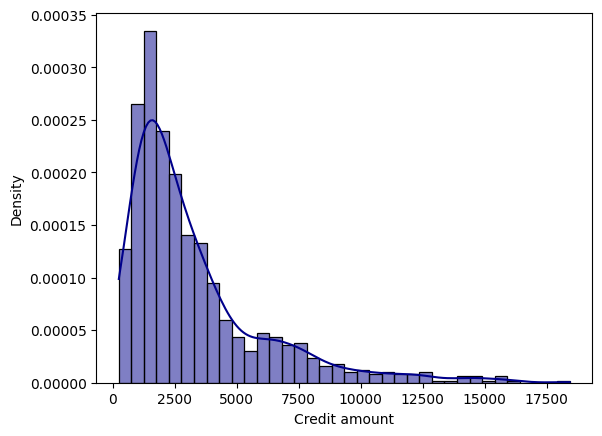

In [13]:
exp.density_plot('Credit amount')


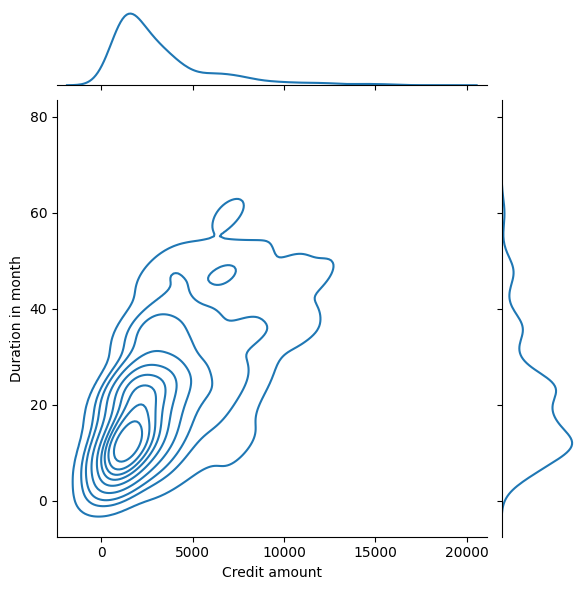

In [14]:
exp.joint_destribution('Credit amount', 'Duration in month')

In [15]:
exp.variable_effect('Credit amount', 0.1, 1)

'-5.590340%'

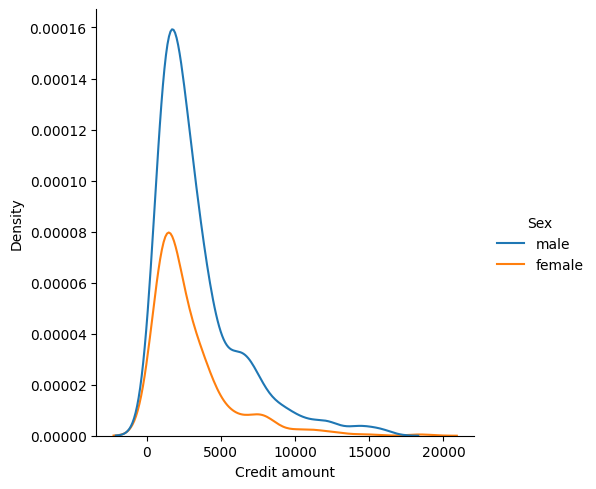

In [16]:
exp.compare_classes('Credit amount')

Metrics for male on cutoff
fpr: 0.502262443438914
tpr: 0.4925373134328358
1-fpr: 0.497737556561086
tf: -0.0052002431282501815
threshold: 0.9975378083540134

Metrics for female on cutoff
fpr: 0.5132275132275133
tpr: 0.48760330578512395
1-fpr: 0.48677248677248675
tf: 0.0008308190126372073
threshold: 0.013282814138539267



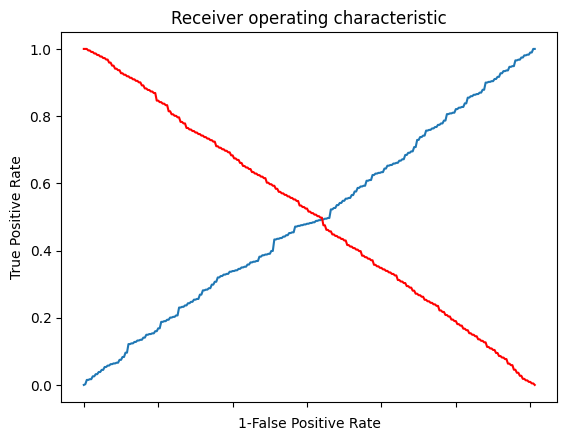

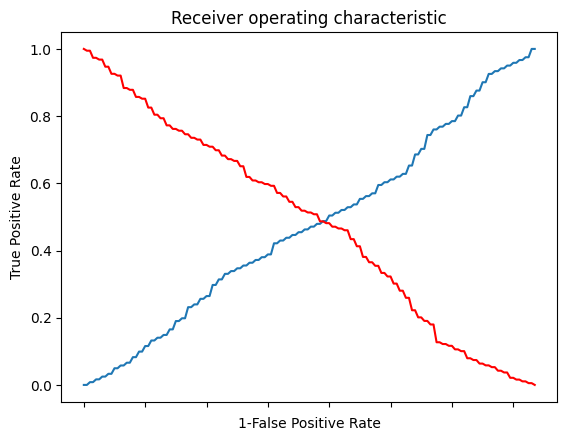

In [17]:
exp.tpr_fpr('Sex')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


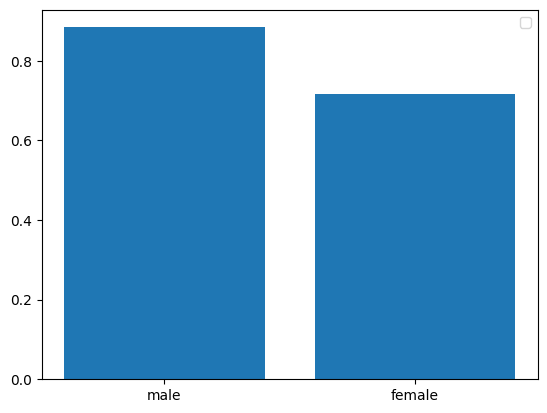

'Процент одобренных среди male = 88.405797%, отклоненных - 11.594203%\nПроцент одобренных среди female = 71.612903%, отклоненных - 28.387097%\n'

In [18]:
exp.accept_percentage('Sex', True)

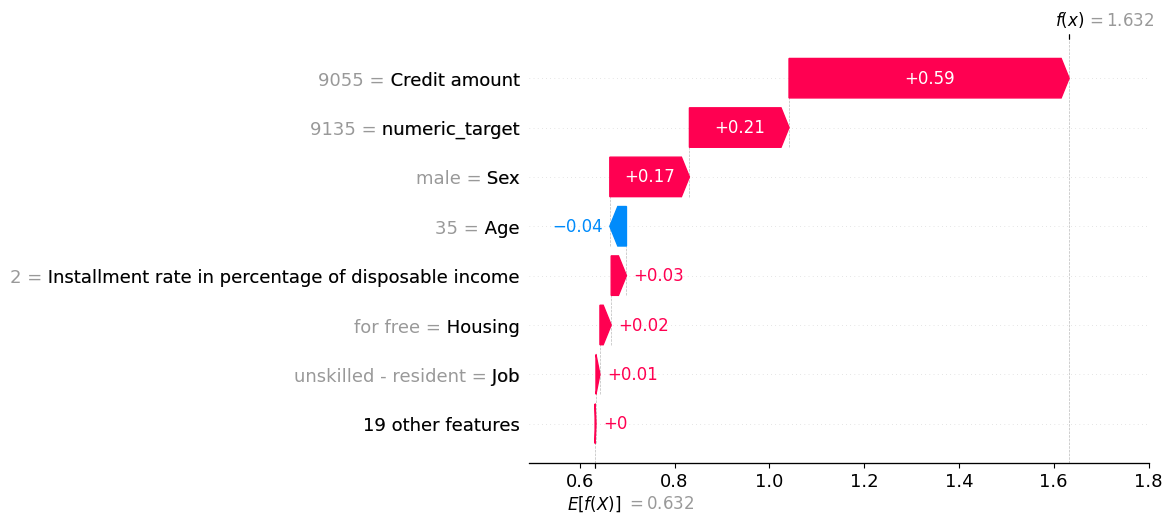

In [19]:
exp.shapper(4)

In [20]:
exp.difference_percentage('Sex', 'cat_target')

'Разница в проценте принятния между female и male составляет -37.36%\nРазница в проценте отклонения между female и male составляет 37.36%\n'

In [21]:
exp.search('cat_target')

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Other debtors / guarantors,Present residence since,...,Number of people being liable to provide maintenance for,Telepthone,Foreign worker,Sex,Personal status,target,numeric_target,cat_target,score,descrete_score
455,no checking account,24,existing credits paid back duly till now,car (used),2679,... < 100 DM,... < 1 year,4,none,1,...,1,"yes, registered under the customers name",no,female,divorced/separated/married,1,2740,1,0.441441,1
866,... < 0 DM,18,existing credits paid back duly till now,radio/television,2389,... < 100 DM,... < 1 year,4,none,1,...,1,none,no,female,divorced/separated/married,1,2442,0,0.044081,1


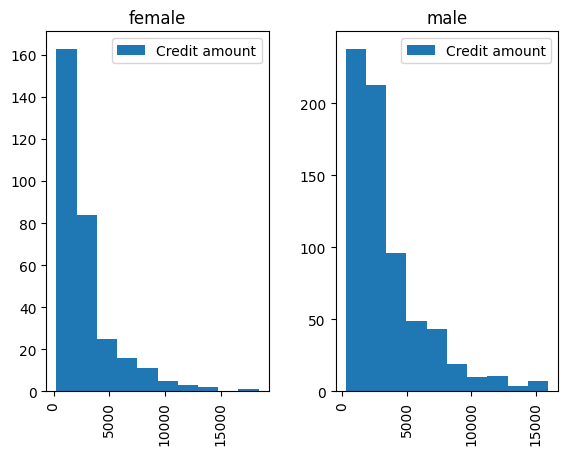

In [22]:
exp.distribution('Credit amount', 'Sex')

In [23]:
exp.result_of_centroid('score')

-0.016670316013875586

In [24]:
exp.mean_protected('Credit amount', 'Sex')

'Среденее значение колонки Credit amount для класса female = 2877.7741935483873\nСреденее значение колонки Credit amount для класса male = 3448.040579710145\n'

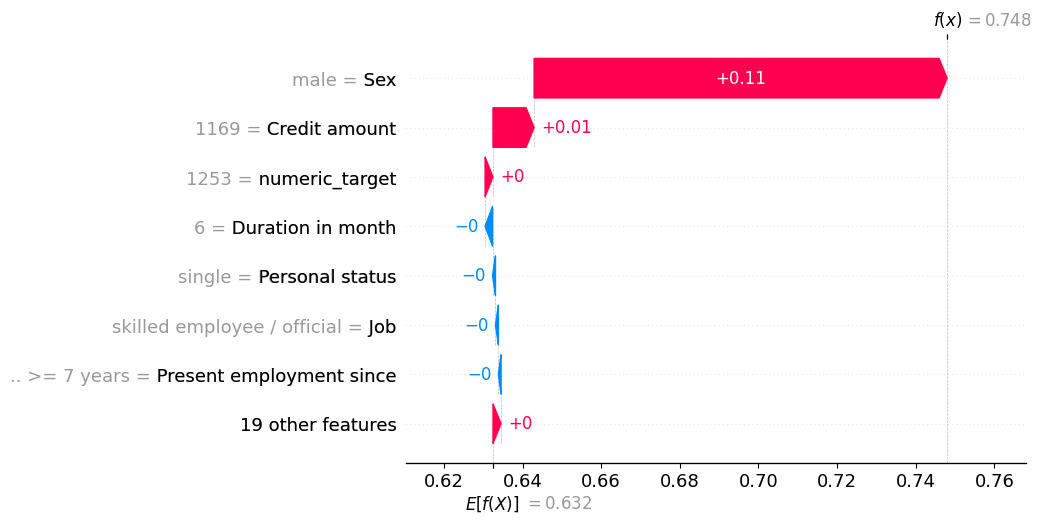

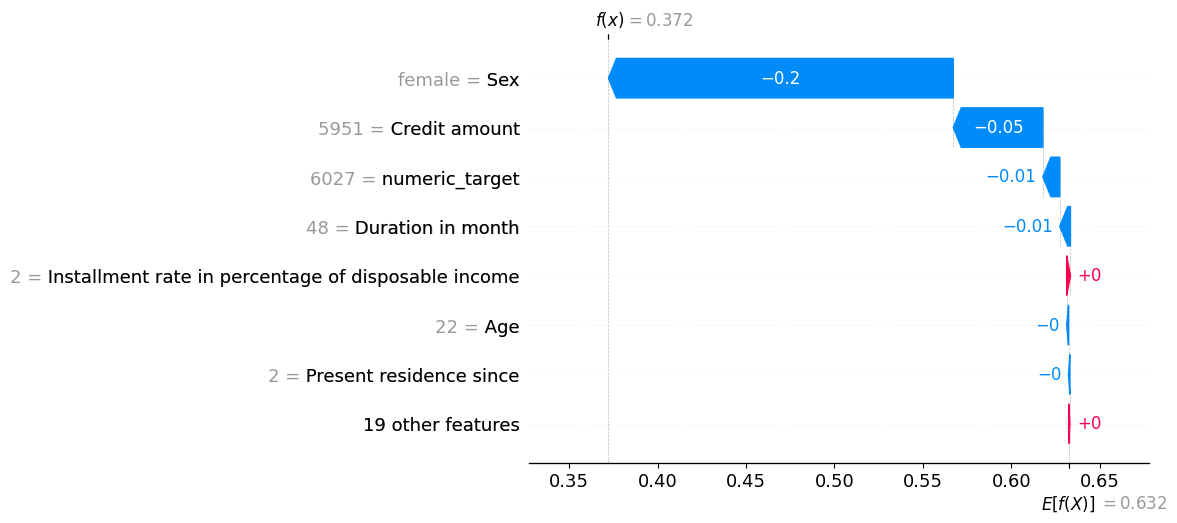

In [25]:
exp.mean_shapper('Sex')

'Среднее значение таргета по классу male = 0.6797101449275362\nСреднее значение таргета по классу female = 0.3903225806451613\n'

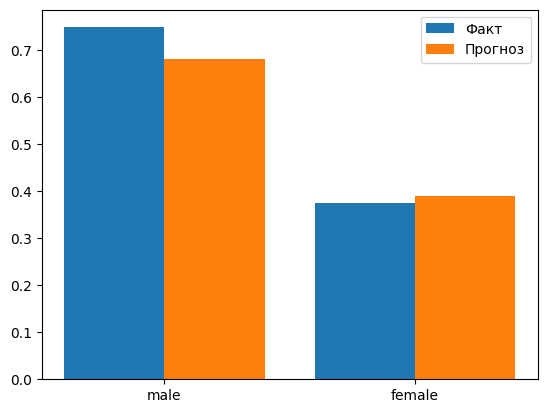

In [26]:
exp.mean_target('Sex', 'target', 'cat_target')

In [ ]:
df.to_csv('data.csv')

In [33]:
from dash import Dash, html, dcc, dash_table, Dash, Input, Output, callback
import dash_bootstrap_components as dbc
import plotly.express as px
import pandas as pd

app = Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dash_table.DataTable(df.to_dict('records'),[{"name": i, "id": i} for i in df.columns], id='tbl',
                         style_cell={'textAlign': 'left'},
                         editable=True),
    dbc.Alert(id='tbl_out'),
])

@callback(Output('tbl_out', 'children'), Input('tbl', 'active_cell'))
def update_graphs(active_cell):
    return str(active_cell) if active_cell else "Click the table"

if __name__ == "__main__":
    app.run(debug=True)


In [57]:
from dash import Dash, dcc, html, Input, Output, dash_table, callback, dependencies
from dash.exceptions import PreventUpdate
import dash
from time import sleep
from random import randint, seed



# For the documentation to always render the same values
def generate_table(df, max_rows=100):
    return dash_table.DataTable(
    id = 'data-table',
    data=df.to_dict('records'),
    columns=[{'id': c, 'name': c} for c in df.columns],
    style_cell={'textAlign': 'left',
                'font-family': 'montserrat',
                'textAlign': 'center',
                'border': 'none'},
    editable=True,
#    style_cell_conditional=[
#        {
#            'if': {'column_id': 'Region'},
#            'textAlign': 'center'
#        }
#    ]
)

app = Dash()

app.layout = html.Div(
    children=[
    dcc.Dropdown(
        id='dropdown',
        ## extend the options to consider unique Fund values as well
        options=[{'label': i, 'value': i} for i in list(df.columns)],
        multi=True, placeholder='Select a column',
        style={'backgroundColor': 'white',
               'width': '25em',
               'margin-bottom': '5em',
               'border-radius': '1em'}),
    html.H1(children='Id', style={'font-family': 'montserrat'}),
    html.Div(id='table-container'),
    
])


@app.callback(dash.dependencies.Output('table-container', 'children'),
    [dash.dependencies.Input('dropdown', 'value')])

def display_table(dropdown_value):
    if dropdown_value is None:
        return generate_table(df)

    ## add an 'or' condition for the other column you want to use to slice the df 
    ## and update the columns that are displayed
    dff = pd.DataFrame(df, columns = dropdown_value)
    return generate_table(dff)

if __name__ == '__main__':
    app.run_server(debug=True)

In [29]:
list(df.columns)

['Status of existing checking account',
 'Duration in month',
 'Credit history',
 'Purpose',
 'Credit amount',
 'Savings account/bonds',
 'Present employment since',
 'Installment rate in percentage of disposable income',
 'Other debtors / guarantors',
 'Present residence since',
 'Property',
 'Age',
 'Other installment plans',
 'Housing',
 'Number of existing credits at this bank',
 'Job',
 'Number of people being liable to provide maintenance for',
 'Telepthone',
 'Foreign worker',
 'Sex',
 'Personal status',
 'target',
 'numeric_target',
 'cat_target',
 'score',
 'descrete_score']